In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


프로젝트 수행 방법
주 데이터는 cars.csv이며, 보조자료로 brand.csv도 준비되어있으니 함께 활용해보세요.

이번 프로젝트에서는 "중고차 가격 예측 모델"을 가정하여 데이터를 준비해볼 수도 있고, "중고차 특성에 따른 클러스터링"을 가정하여 데이터를 준비해볼 수도 있습니다.

아직 머신러닝 알고리즘을 학습하기 전 단계이니, 배웠던 내용을 최대한 활용하여 다양하게 데이터를 변환해보세요.

만약 이전에 배웠던 학습 내용이 익숙하지 않다면 이전 내용을 다시 한번 복습해 주세요. 🤗


Step 1. 이것만큼은 꼭 해보세요!
프로젝트에 정답은 없습니다. 배우신 내용을 토대로 자유롭게 데이터를 정제하고 변환하되, 아래 내용만큼은 반드시 실습해봅시다.

cars.csv와 brand.csv의 데이터 합치기
[힌트] cars.csv의 title 변수로부터 브랜드 데이터를 추출할 수 있습니다.
카테고리형 변수를 숫자 형태로 변환하기
[힌트] Engine, Emission Class 변수에 주목하세요!
결측치 처리하기
[힌트] Service history 변수의 결측치는 'Unknown'으로 채우고, 결측치 변수가 일정 개수 이상 포함된 데이터는 제거합니다.
Scaler 활용해보기
기존 데이터의 정보 70% 이상을 가지는 수준에서 최소한의 주성분 추출 (PCA)


자유롭게 실습을 해보시고, 여유가 되면 아래의 내용도 실습해보세요.

국가별 총 브랜드 개수는?
상관관계가 높은 변수들이 있는지 확인해보세요.

[오늘의 과정에서 해볼 것] : 중고차 가격 예측 모델을 위한 데이터 분석 및 준비
1. 데이터 확인
2. 데이터 결합
3. 결측치 처리
4. 카테고리형 -> 숫자형 변환
5. 스케일링으로 데이터 단위 표준화/정규화
6. PCA 로 차원 축소

[선택 실습]
1. 국가별 총 브랜드 개수를 살펴 나라별 브랜드 다양성 보기 : groupgy('Country').unique()
2. 변수간 상관관계 확인으로 가격에 영향 높은 변수 찾기 : .corr() / sns.heatmap 등

In [4]:
#데이터 분석 기본 세팅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#데이터 불러오기
cars = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cars.csv')

In [6]:
brand = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/brand.csv')

In [7]:
#데이터 쓱 둘러보기
cars.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [8]:
cars.info()
cars.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    2276 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3642 non-null   object 
 8   Gearbox            3687 non-null   object 
 9   Doors              3662 non-null   float64
 10  Seats              3652 non-null   float64
 11  Emission Class     3600 non-null   object 
 12  Service history    540 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 374.6+ KB


(3687, 13)

In [9]:
brand.head()

,title,country
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,ford,United States


In [10]:
brand.info()
brand.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    48 non-null     object
 1   country  48 non-null     object
dtypes: object(2)
memory usage: 900.0+ bytes


(48, 2)

In [11]:
# cars 파일의 title이 길고, 브랜드 파일의 title은 짧음. 그리고 대소문자도 서로 다름. 긴쪽의 앞단어만 선택, 소문자+공백처리로 값을 정규화해주기!

#띄어쓰기 기준 분리 후 앞만 선택
cars['Brand'] = cars['title'].str.split().str[0]

#brand 파일의 컬럼명 정리
brand = brand.rename(columns = {'title' : 'Brand', 'country' : 'Brand_Country' })

#소문자 통일 및 공백 제거 (병합키)
cars['Brand_new'] = cars['Brand'].str.strip().str.lower()
brand['Brand_new'] = brand['Brand'].str.strip().str.lower()

#정리한 Brand_new 기준으로 두 파일 병합해주기 (데이터프레임에서 여러열 선택시 대괄호 두번)
cars_new = pd.merge(cars, brand[['Brand_new', 'Brand_Country']], on = 'Brand_new', how = 'left')

In [12]:
cars_new.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,Brand,Brand_new,Brand_Country
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,SKODA,skoda,Czech Republic
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,VAUXHALL,vauxhall,United Kingdom
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,HYUNDAI,hyundai,South Korea
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,MINI,mini,United Kingdom
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,VAUXHALL,vauxhall,United Kingdom


In [13]:
#중복되는 Brand 컬럼은 삭제 (에러 자꾸 나서 errors = 'ignore')르 사용하니 해결됨
cars_new = cars_new.drop(columns = ['Brand'], errors='ignore')

In [14]:
#깔끔하게 다시 브랜드랑 브랜드 국가 이름 재정리
cars_new = cars_new.rename(columns={'Brand_new' : 'Brand'})
cars_new.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,Brand,Brand_Country
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,skoda,Czech Republic
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,vauxhall,United Kingdom
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,hyundai,South Korea
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,mini,United Kingdom
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,vauxhall,United Kingdom


In [15]:
cars_new.info()
cars_new.shape

#결측치 많은 컬럼. Service history (매우높음), Previous Owners (상당함), Doors / Seats / Engine / Emission Class(일부 결측들이므로 처리하자!)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    2276 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3642 non-null   object 
 8   Gearbox            3687 non-null   object 
 9   Doors              3662 non-null   float64
 10  Seats              3652 non-null   float64
 11  Emission Class     3600 non-null   object 
 12  Service history    540 non-null    object 
 13  Brand              3687 non-null   object 
 14  Brand_Country      3687 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 432.2+ KB


(3687, 15)

In [16]:
#Service history 결측처리
cars_new['Service history'] = cars_new['Service history'].fillna('Unknown')


In [17]:
#한 컬럼 내 고유값 빈도수 확인  그리고 이게 이미 정수형 처리 되어있음 확인
cars_new['Service history'].value_counts()

,count
Service history,
Unknown,3147
Full,540


In [18]:
#정보량이 일정 수준 이상 빠진 샘플(행)은 제거/ thresh=N 결측이 아닌 값이 최소 N개 이상은 있어야 남긴다. (결측이 있는 컬럼이 5개 정도로 파악되므로)
cars_new = cars_new.dropna(thresh = 10)
cars_new.isna().sum()

,0
title,0
Price,0
Mileage(miles),0
Registration_Year,0
Previous Owners,1411
Fuel type,0
Body type,0
Engine,45
Gearbox,0
Doors,25


In [19]:
#Previous Owners 는 결측이 많으나 정보 부재가 현재 소유주 1명만 거쳤다는 의미인지 정보없음인지 모르니 그냥 정보없음 처리로 (자료형이 float이므로 -1처리로)
cars_new['Previous Owners'] = cars_new['Previous Owners'].fillna(-1)

In [20]:
# 남은 결측 컬럼 특성 확인
# Engine(단위문자가 포함된 수치 - 카테고리형) : 범주형 결측은 1차로 Unknown 처리 -> 나중에 원핫인코딩할거임
# Emission Class(문자로 된 수치 등급 - 카테고리형)

cars_new['Engine'] = cars_new['Engine'].fillna('Unknown')
cars_new['Emission Class'] = cars_new['Emission Class'].fillna('Unknown')

# Doors(1-5개 예상: 수치형 -> 중앙값 대체)
# Seats(2-9인승 예상 :수치형 -> 중앙값 대체)


In [25]:
cars_new[['Engine', 'Emission Class']].isna().sum() #위 처리 결과 확인


,0
Engine,0
Emission Class,0


In [26]:
#수치형 결측 컬럼 처리 -> 중앙값으로 대체하여 채우기

cars_new[['Doors', 'Seats']].isna().sum()

,0
Doors,25
Seats,35


In [27]:
cars_new['Doors'] = cars_new['Doors'].fillna(cars_new['Doors'].median())

In [28]:
cars_new['Seats'] = cars_new['Seats'].fillna(cars_new['Seats'].median())

In [29]:
cars_new[['Doors', 'Seats']].isna().sum()

,0
Doors,0
Seats,0


In [30]:
cars_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    3687 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3687 non-null   object 
 8   Gearbox            3687 non-null   object 
 9   Doors              3687 non-null   float64
 10  Seats              3687 non-null   float64
 11  Emission Class     3687 non-null   object 
 12  Service history    3687 non-null   object 
 13  Brand              3687 non-null   object 
 14  Brand_Country      3687 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 432.2+ KB


In [32]:
#카테고리형 컬럼은 모델에 넣을 수 있는 형태로 바꾸기 위해 원앤핫인코딩으로 변환시키기
#과제에서 요구하는 결측치 컬럼 중 오브젝트형 (Engine, Emission Class) 먼저 숫자형으로 변환

#인코딩 할 컬럼명 리스트로 일단 묶어두기
cat_vars = ['Engine', 'Emission Class']

#인코딩
cars_encoded = pd.get_dummies(cars_new, columns = cat_vars, drop_first = True, dtype = int)


In [33]:
cars_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   3687 non-null   object 
 1   Price                   3687 non-null   int64  
 2   Mileage(miles)          3687 non-null   int64  
 3   Registration_Year       3687 non-null   int64  
 4   Previous Owners         3687 non-null   float64
 5   Fuel type               3687 non-null   object 
 6   Body type               3687 non-null   object 
 7   Gearbox                 3687 non-null   object 
 8   Doors                   3687 non-null   float64
 9   Seats                   3687 non-null   float64
 10  Service history         3687 non-null   object 
 11  Brand                   3687 non-null   object 
 12  Brand_Country           3687 non-null   object 
 13  Engine_0.9L             3687 non-null   int64  
 14  Engine_1.0L             3687 non-null   

In [34]:
#열이 많아졌으니 스케일링과 PCA로 통계적으로 다듬고 차원 축소시켜보자.
#스케일링은 서로 단위와 범위가 다른 변수를 같은 기준 축 위에 올려주는 과정임.
cars_encoded.describe()   #프라이스 편차 너무 큼. 마일즈도 단위 너무 크고 편차 너무 큼. 프리비어스오너는 상대적으로 값 범주가 좁음(). 연도는 범주 평균이 다른 컬럼대비 높은 숫자임(스케일링)

,Price,Mileage(miles),Registration_Year,Previous Owners,Doors,Seats,Engine_0.9L,Engine_1.0L,Engine_1.1L,Engine_1.2L,...,Engine_5.0L,Engine_5.5L,Engine_6.3L,Engine_Unknown,Emission Class_Euro 2,Emission Class_Euro 3,Emission Class_Euro 4,Emission Class_Euro 5,Emission Class_Euro 6,Emission Class_Unknown
count,3687.000000,3.687000e+03,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,...,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000
mean,5787.301058,8.132854e+04,2011.846216,1.350420,4.326010,4.901275,0.004068,0.088419,0.010578,0.141307,...,0.000814,0.000271,0.000271,0.012205,0.006781,0.037158,0.289666,0.340928,0.300787,0.023596
std,4480.629885,3.941718e+04,5.082387,2.213831,0.984984,0.574382,0.063662,0.283941,0.102316,0.348386,...,0.028517,0.016469,0.016469,0.109815,0.082076,0.189173,0.453669,0.474085,0.458662,0.151809
min,400.000000,1.000000e+00,1953.000000,-1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2490.000000,5.698400e+04,2008.000000,-1.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4000.000000,8.000000e+04,2012.000000,1.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7995.000000,1.030000e+05,2015.500000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,33900.000000,1.110100e+06,2025.000000,9.000000,5.000000,7.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

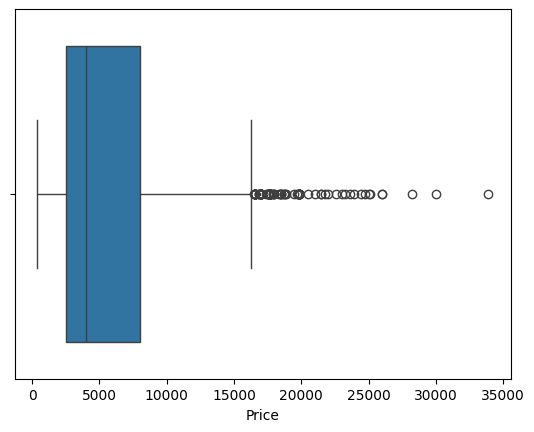

In [35]:
#스케일링 가기 전 이상치 부분 확인을 위해 시각화로 후보 컬럼 몇개만 확인
import matplotlib.pyplot as plt
import seaborn as sns

#Price 분포 보기
sns.boxplot(x=cars_encoded['Price'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

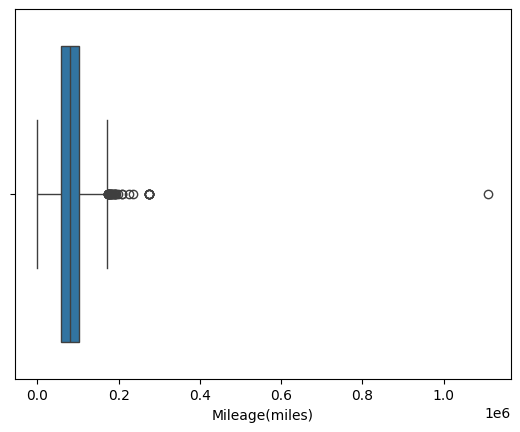

In [36]:
#Mileage(주행거리) 분포 보기
sns.boxplot(x=cars_encoded['Mileage(miles)'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

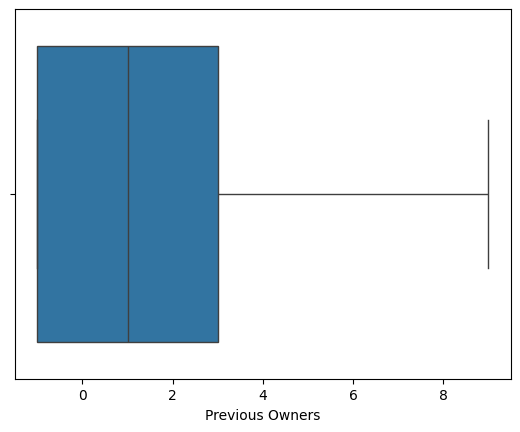

In [37]:
#Previous Owners(이전 소유자수)분포 보기
sns.boxplot(x=cars_encoded['Previous Owners'])
plt.show

In [42]:
#환경 세팅한 뒤, 스케일링 대상 변수 선택 - 인코딩 컬럼은 제외하고 door나 seats처럼 범주 적고 해석단위 작은 경우 제외

#이상치 몇 개 튀는 것들이 위의 시각화에서 관찰되었으므로 RobustScaler는 중앙값 기준 이상치 영향 최소화이므로 이걸 선택

from sklearn.preprocessing import RobustScaler

scale_cols = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners']

scaler = RobustScaler() #스케일러라는 객체 만들기
cars_scaled = pd.DataFrame(scaler.fit_transform(cars_encoded[scale_cols]))


In [43]:
#스케일러 적용 결과 전 후 확인
cars_encoded[scale_cols].describe()

,Price,Mileage(miles),Registration_Year,Previous Owners
count,3687.000000,3.687000e+03,3687.000000,3687.000000
mean,5787.301058,8.132854e+04,2011.846216,1.350420
std,4480.629885,3.941718e+04,5.082387,2.213831
min,400.000000,1.000000e+00,1953.000000,-1.000000
25%,2490.000000,5.698400e+04,2008.000000,-1.000000
50%,4000.000000,8.000000e+04,2012.000000,1.000000
75%,7995.000000,1.030000e+05,2015.500000,3.000000
max,33900.000000,1.110100e+06,2025.000000,9.000000


In [44]:
cars_scaled.describe()  #데이터 중앙값이 잘 0으로 바뀌어서 적용 완료됨

,0,1,2,3
count,3687.000000,3687.000000,3687.000000,3687.000000
mean,0.324669,0.028871,-0.020504,0.087605
std,0.813920,0.856597,0.677652,0.553458
min,-0.653951,-1.738504,-7.866667,-0.500000
25%,-0.274296,-0.500174,-0.533333,-0.500000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.725704,0.499826,0.466667,0.500000
max,5.431426,22.385692,1.733333,2.000000


In [45]:
#주성분 분석으로 차원축소 진행 - 비슷한 정보가 중복된 변수를 합쳐 데이터를 단순, 효율 분석하기 쉽게 만들고 분산을 가장 잘 설명하는 방향으로 표현함 -> 모델링에 용이한 상태로 만들어줌
from sklearn.decomposition import PCA

pca = PCA() #PCA 객체 생성

pca_transformed = pca.fit_transform(cars_scaled) #PCA 학습 및 변환 적용


In [48]:
#주성분별 분산 비율 확인 - PCA1,2의 합이 0.798이니까 약 80% 정보유지하므로 n_components= 2로 설정
explained = pca.explained_variance_ratio_
explained

array([0.60526092, 0.19339361, 0.13312043, 0.06822504])

In [49]:
#찾은 최소축 수 PCA 반영

pca_final = PCA(n_components = 2)
cars_pca = pca_final.fit_transform(cars_scaled)



In [52]:
#결과 확인  - 컬럼이 2개로 차원 축소 되었는지 확인
cars_pca.shape

(3687, 2)

In [54]:
pca_final.components_. #2행 4열 형태의 어레이구조

array([[ 0.63186157, -0.60015792,  0.47331254, -0.12859495],
       [ 0.43595799,  0.77861076,  0.43648241,  0.11484346]])

In [55]:
#PCA 주성분에 해당되는 변수별 영향(기여도) 확인 - 위의 결과를 2열 4행으로 전치 시켜서 보기 / round(3) 소수점 3자리까지 반올림
feature_ratio = pd.DataFrame(pca_final.components_.T, index = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners'], columns = ['PC1', 'PC2']).round
feature_ratio

,PC1,PC2
Price,0.632,0.436
Mileage(miles),-0.600,0.779
Registration_Year,0.473,0.436
Previous Owners,-0.129,0.115


PCA 축 해석하는 법 : 기여도의 크기(=중요도)는 절대값으로 보고, 부호(+, −) 는 관계의 방향을 의미

*  PC1 = 차량의 가치 축 (연식, 저주행, 고가) / PC2 = 주행거리(사용량) 중심의 보조축
*   양축 다 이전소요자의 수는 주성분에 기여도 낮음




In [57]:
#내용을 보니, 가격에 영향을 주는 것은 연식과 주행거리가 가장 연관성이 있어보임. 이거를 corr를 이용한 변수간 상관관계 확인 후 시각화 해보기
corr_df = cars_encoded[['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners']].corr()
corr_df

,Price,Mileage(miles),Registration_Year,Previous Owners
Price,1.000000,-0.500358,0.722971,-0.173554
Mileage(miles),-0.500358,1.000000,-0.410781,0.190335
Registration_Year,0.722971,-0.410781,1.000000,-0.142582
Previous Owners,-0.173554,0.190335,-0.142582,1.000000


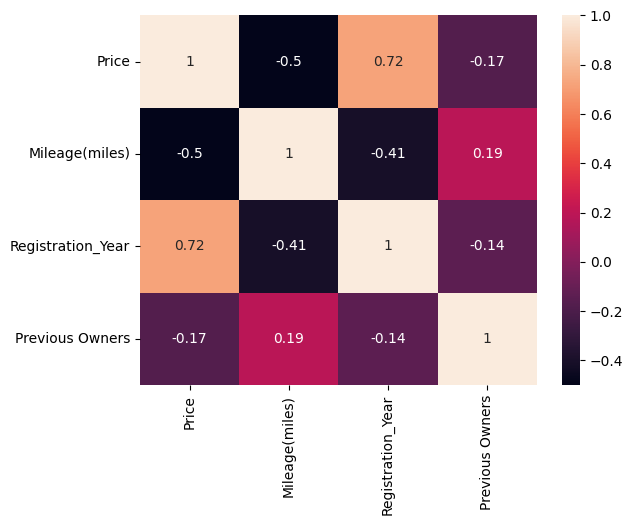

In [60]:
sns.heatmap(corr_df, annot = True)
plt.show()

결국 수치형 변수 중에서 가격에 영향을 가장 많이 끼치는 것은 연식 (Registration_Year) 인 것으로 확인할 수 있음.

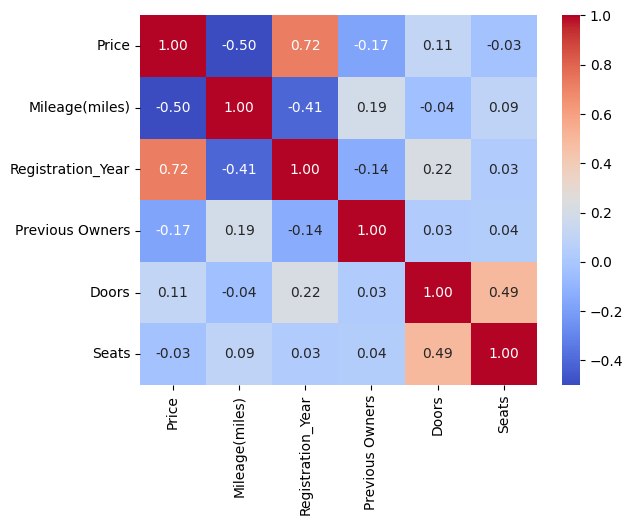

In [63]:
#전체 데이터 안의 수치변수 간의 상관관계 시각화해보기

numeric_cols = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners', 'Doors', 'Seats']

corr_numeric = cars_encoded[numeric_cols].corr()
sns.heatmap(corr_numeric, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.show()

붉은색 : 양의 상관성  / 파란색 : 음의 상관성
가격과 연식  - 양의 상관성 0.72: 신형일수록 가격이 높다
가격과 주행거리 - 음의 상관성 -0.5 : 많이 탈수록 가격이 낮다
주행거리와 연식 - 음의 상관성 -0.41 : 많이 탄 차량일수록 구형
Previous Owners, Door, seats 등 변수간 상관계수의 절대값이 낮은 애들은 연관성이 낮다 여겨짐

In [ ]:
#[추가실습] 나라별 차 브랜드 개수를 살펴 다양성 확인해보기

In [64]:
cars_new.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,Brand,Brand_Country
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,Unknown,skoda,Czech Republic
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,vauxhall,United Kingdom
2,HYUNDAI I30,949,137000,2011,-1.0,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,Unknown,hyundai,South Korea
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,mini,United Kingdom
4,VAUXHALL CORSA,1000,85000,2013,-1.0,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,Unknown,vauxhall,United Kingdom


In [66]:
cars_new.groupby('Brand_Country')['Brand'].unique() #고유값들 먼저 뭐 있는지 나라별 구분

,Brand
Brand_Country,
Czech Republic,[skoda]
France,"[peugeot, citroen, renault, ds]"
Germany,"[bmw, mercedes-benz, volkswagen, audi, porsche..."
Italy,"[alfa, fiat, abarth, maserati]"
Japan,"[mazda, honda, toyota, nissan, mitsubishi, lex..."
Malaysia,[proton]
Romania,[dacia]
South Korea,"[hyundai, kia, daewoo, ssangyong]"
Spain,[seat]


In [67]:
cars_new.groupby('Brand_Country')['Brand'].nunique()

,Brand
Brand_Country,
Czech Republic,1
France,4
Germany,6
Italy,4
Japan,11
Malaysia,1
Romania,1
South Korea,4
Spain,1


일본이 브랜드가 가장 다양하고, 그 다음이 영국, 독일, 미국 순임.